# Sources of Opacity

Within the ejecta there are several sources of opacity for the $\gamma$-rays that we need to take into account. Each source of opacity has its own function in the code. The following cells show each source of opacity and how they are implemented in the code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tardis import constants as const
from tardis.opacities.opacities import compton_opacity_calculation
from tardis.opacities.opacities import photoabsorption_opacity_calculation
from tardis.opacities.opacities import pair_creation_opacity_calculation
%config InlineBackend.figure_format = 'retina'

In [2]:
energies = np.arange(10, 10000, 0.01) # in KeV

The values are taken from the $k^{th}$ shell at time $t_i$

In [3]:
ejecta_density = 1.25e-10  # g/cm^3
electron_density = 3.57e11  # cm^-3
x_ige = 0.01

## Pair Creation

Pair Creation is dominant when the energy of the $\gamma$-ray is greater than or equal to $2m_e c^2$.
It occurs when a $\gamma$-ray interacts with an atomic nucleus and creates an electron-positron pair. 

![Pair Production Diagram](images/pair_production_diagram.jpg)

*Image from [Wikidot](http://electrons.wikidot.com/pair-production-and-annihilation)*

The positron forms a bound-state with an electron called positronium which decay into two photons at 0.511 MeV or three photons. 
The photon packet keeps its energy but is sent into a new direction.
The pair-production coefficients ($cm^{-1}$) as given in <strong data-cite="Hubbell1969">[]</strong>  <strong data-cite="Ambwani1988">[]</strong> (see Equation 2) are:

$$
\alpha_{pp}(1.5 < h\nu < 1.022 MeV) = \rho \left[ \frac{Z_{\text{Si}}^2}{m_{\text{Si}}} (1 - X_{\text{IGE}}) + \frac{Z_{\text{Fe}}^2}{m_{\text{Fe}}} X_{\text{IGE}} \right] 1.0063 (h\nu - 1.022 MeV) \times 10^{-27}
$$

$$
\alpha_{pp}(h\nu \geq 1.5 MeV) = \rho \left[ \frac{Z_{\text{Si}}^2}{m_{\text{Si}}} (1 - X_{\text{IGE}}) + \frac{Z_{\text{Fe}}^2}{m_{\text{Fe}}} X_{\text{IGE}} \right] \left[ 0.0481 + 0.301(h\nu - 1.5 MeV) \right] \times 10^{-27}
$$


$\rho$ is the mass density of the ejecta and $X_{\text{IGE}}$ is the mass fraction of Fe-group elements.

Text(0.5, 1.0, 'Pair Creation Attenuation Coefficient')

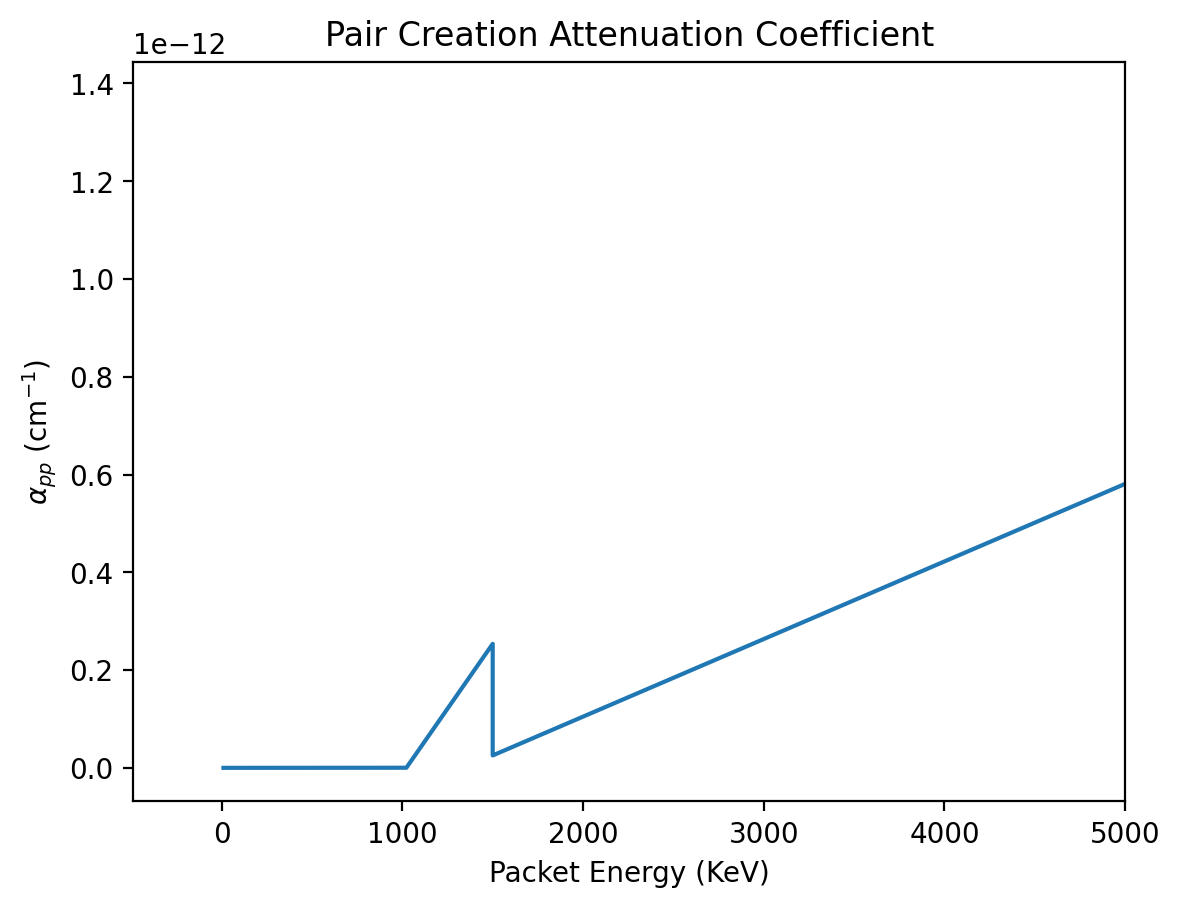

In [4]:
pair_creation_opacities = np.zeros(len(energies))
for i in range(len(energies)):
    pair_creation_opacities[i] = pair_creation_opacity_calculation(energy=energies[i], ejecta_density=ejecta_density, iron_group_fraction=x_ige)

# We can then plot the opacity 
plt.plot(energies, pair_creation_opacities)
plt.xlabel("Packet Energy (KeV)")
plt.ylabel(r"$\alpha_{pp}$ (cm$^{-1}$)")
plt.xlim(right= 5000)
plt.title("Pair Creation Attenuation Coefficient")

## Compton Scattering

Compton scattering is inelastic scattering that occurs when a high energy photon collides with an electron. Unlike Thomson scattering, which is elastic, during the collision some of the energy from the photon is transferred to the electron and the scattered photon is lower energy than the incident photon. 
This means that the scattered photon also has a lower frequency and a longer wavelength. In the simulation we assume that the electrons are moving significantly slower than the photons.

![Compton Scattering Diagram](images/compton_diagram.png)

*Image from [Wikipedia](https://en.wikipedia.org/wiki/Compton_scattering)*

A high energy photon with an energy $e$ after scattering through an angle $\theta$ loses its energy by the fraction $f$.

$$
f = \frac{1}{1 + x(1 - \cos{\theta})}
$$

Where $\theta$ is the angle the photon is scattered at and $x = \frac{h \nu}{m_e c^2}$

The partial cross section from 0 to $\theta$ in terms of f as given in the [ARTIS](https://github.com/artis-mcrt/artis) code <strong data-cite="Sim2007">[]</strong> <strong data-cite="Kromer2009">[]</strong> is:

$$
\sigma(f) = \frac{3 \sigma_T}{8x} \frac{\left( x^2 - 2x - 2 \right) \ln(f)}{x^2} + \frac{f^2 - 1}{2f^2} +  \frac{f - 1}{x} [\frac{1}{x} + \frac{2}{f} + \frac{1}{xf}]
$$
   
Where $f$ can range from $1$ to $\frac{1}{1+2x}$ and $\sigma_T$ is the Thomson scattering cross section.

The scattering angle is given by:

$$
\theta = \cos^{-1}({1 - \frac{f-1}{x}})
$$

The total integrated Compton scattering coefficient <strong data-cite="Weinberg1995">[]</strong> is:

$$
\alpha_C = n_e \frac{3}{4} \sigma_T [\frac{1+x}{x^3} (\frac{2x(1 + x)}{1 + 2x} - \ln(1 + 2x)) + \frac{1}{2x} \ln(1 + 2x) - \frac{1 + 3x}{(1 + 2x)^2}]
$$

Where $n_e$ is the number density of electrons.


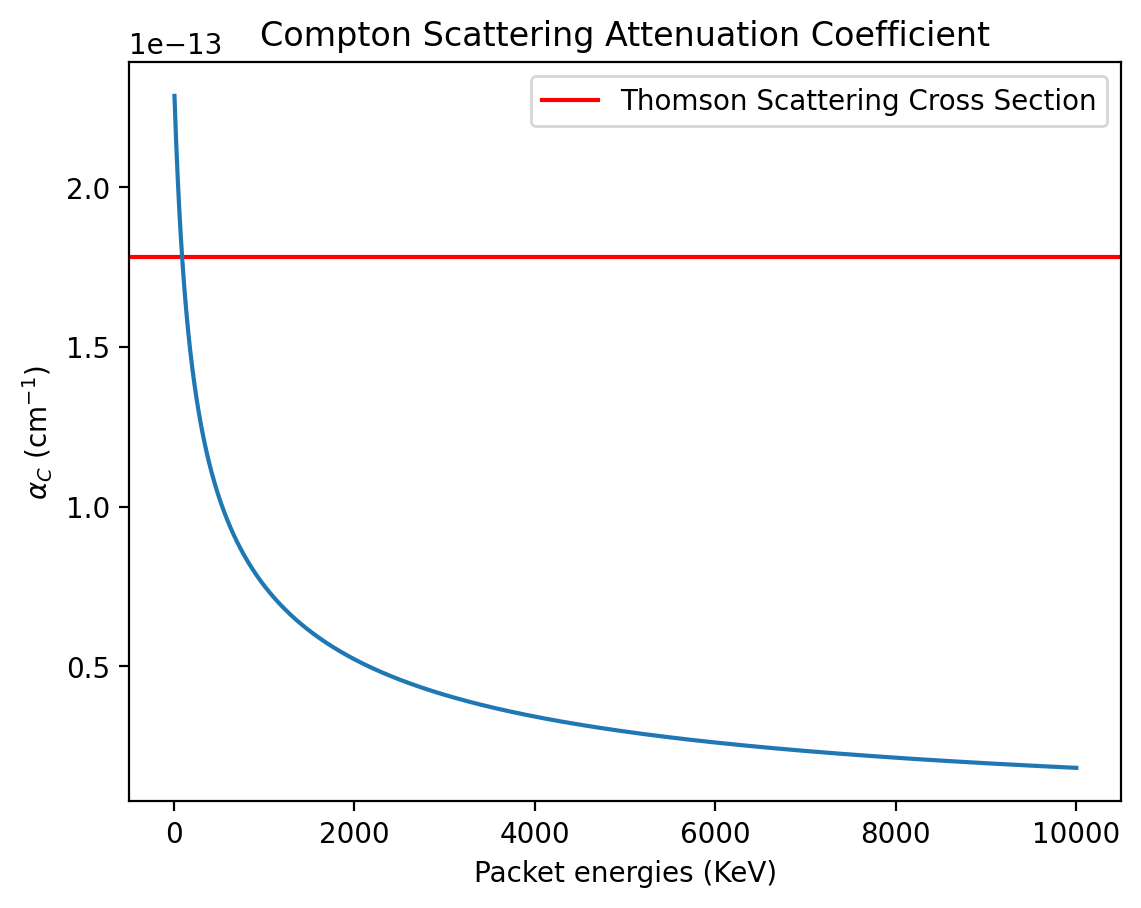

In [5]:
compton_opacities = compton_opacity_calculation(energies, electron_density)
plt.axhline(const.sigma_T.cgs.value*electron_density*.75, color = "red", label = "Thomson Scattering Cross Section")
plt.plot(energies, compton_opacities)
plt.xlabel("Packet energies (KeV)")
plt.ylabel(r"$\alpha_{C}$ (cm$^{-1}$)")
plt.title("Compton Scattering Attenuation Coefficient")
plt.legend()

## Photoabsorption

This occurs when the photon is completely absorbed by a material. We assume that the $\gamma$-ray deposits all of its energy when this occurs.
The coefficient as given in <strong data-cite="Veigele1973">[]</strong> <strong data-cite="Ambwani1988">[]</strong> (see Equation 3) is:

$$
\alpha_{pa}(\nu) = 1.16 \times 10^{-24} (\frac{h\nu}{100 keV})^{-3.13}  \frac{\rho}{m_{\text{Si}}} (1 - X_{\text{IGE}}) + 25.7 \times 10^{-24} (\frac{h\nu}{100 keV})^{-3}  \frac{\rho}{m_{\text{Fe}}} X_{\text{IGE}}
$$

(5.0, 50.0)

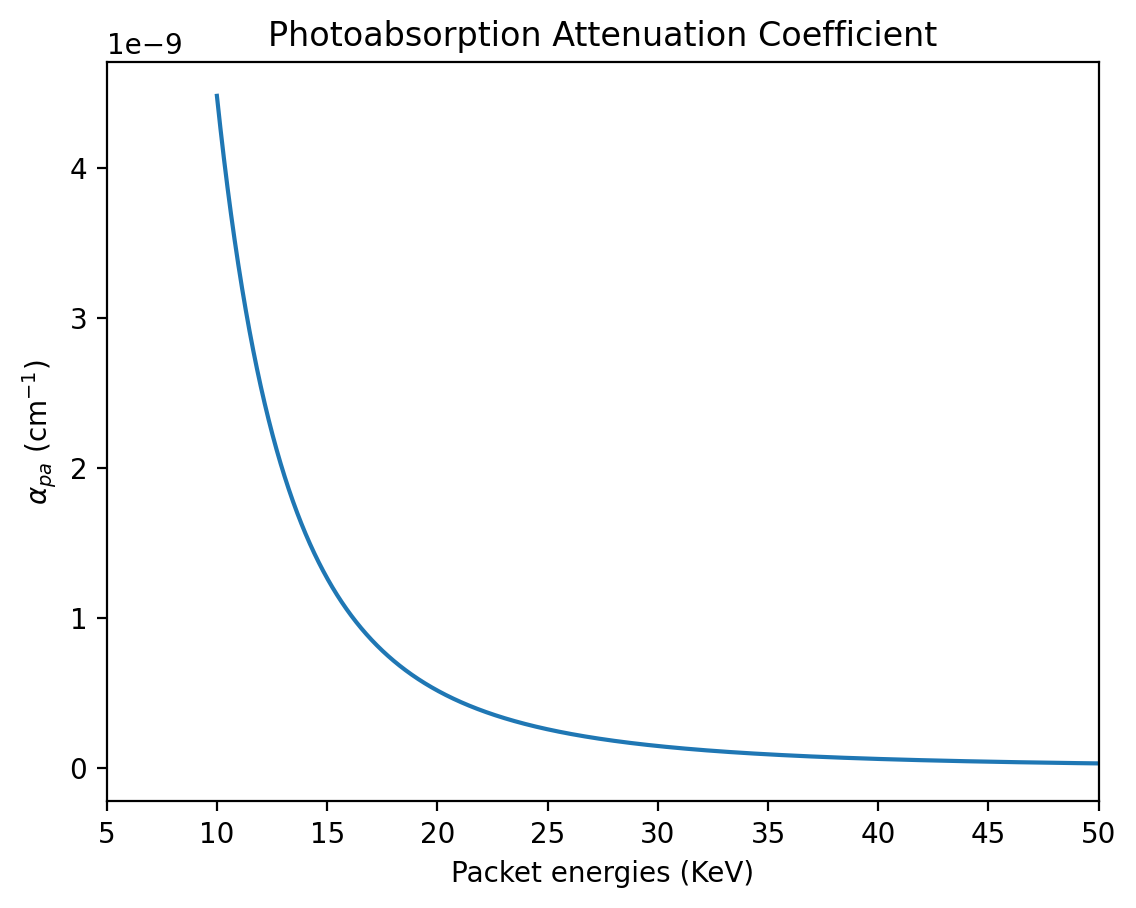

In [6]:
# The photoabsorption opacity function takes in the packet energy, ejecta density and the fraction of iron group elements
photoabsorption_opacities = photoabsorption_opacity_calculation(energy= energies, ejecta_density=ejecta_density, iron_group_fraction=x_ige)

plt.plot(energies, photoabsorption_opacities)
plt.xlabel("Packet energies (KeV)")
plt.ylabel(r"$\alpha_{pa}$ (cm$^{-1}$)")
plt.title("Photoabsorption Attenuation Coefficient")
plt.xlim(5,50)

The different forms of opacity are dominant at different energies which is evident when the opacities are plotted together.

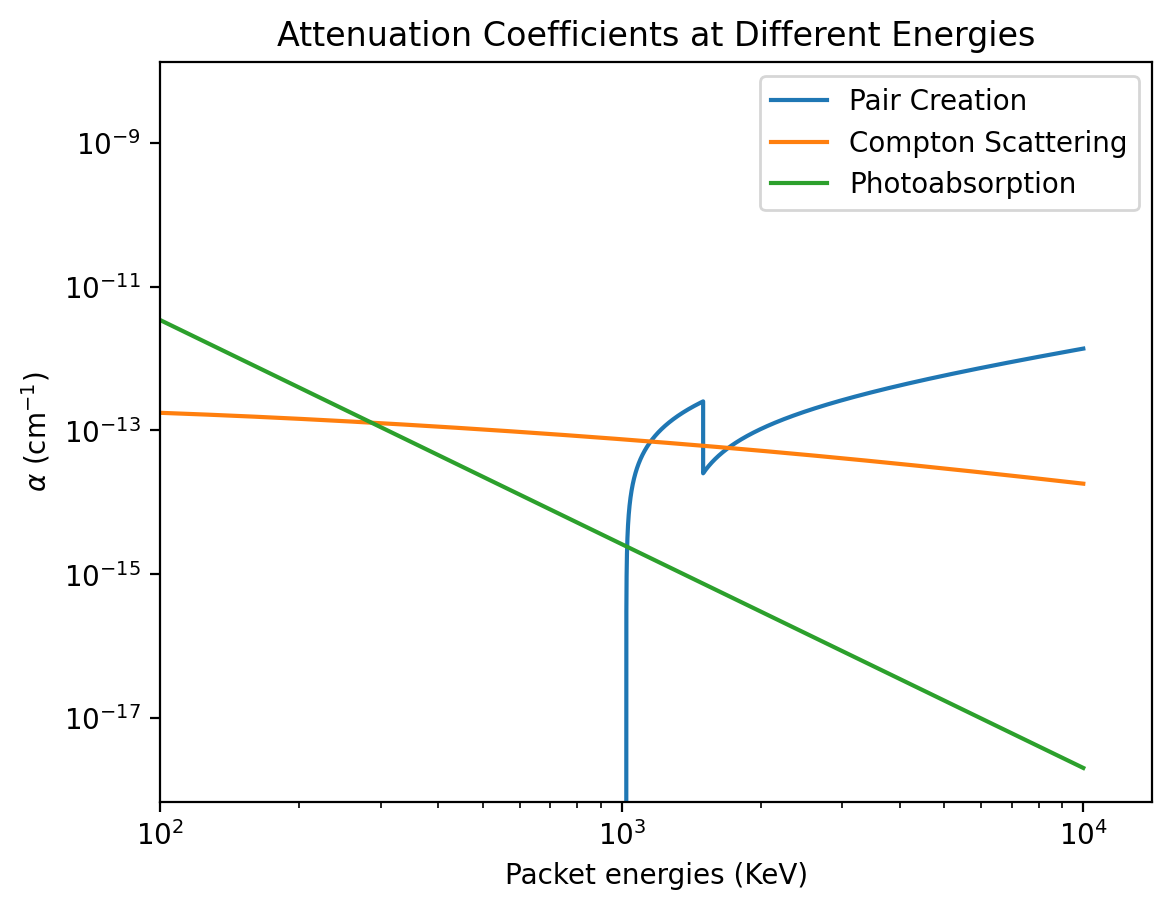

In [8]:
plt.plot(energies, pair_creation_opacities, label = "Pair Creation")
plt.plot(energies, compton_opacities, label= "Compton Scattering")
plt.plot(energies, photoabsorption_opacities, label= "Photoabsorption")
plt.xlabel("Packet energies (KeV)")
plt.ylabel(r"$\alpha$ (cm$^{-1}$)")
plt.title("Attenuation Coefficients at Different Energies")
plt.yscale("log")
plt.xscale("log")
plt.xlim(left = 100)
plt.legend()

Text(0, 0.5, 'Fraction of Total Attenuation Coefficient')

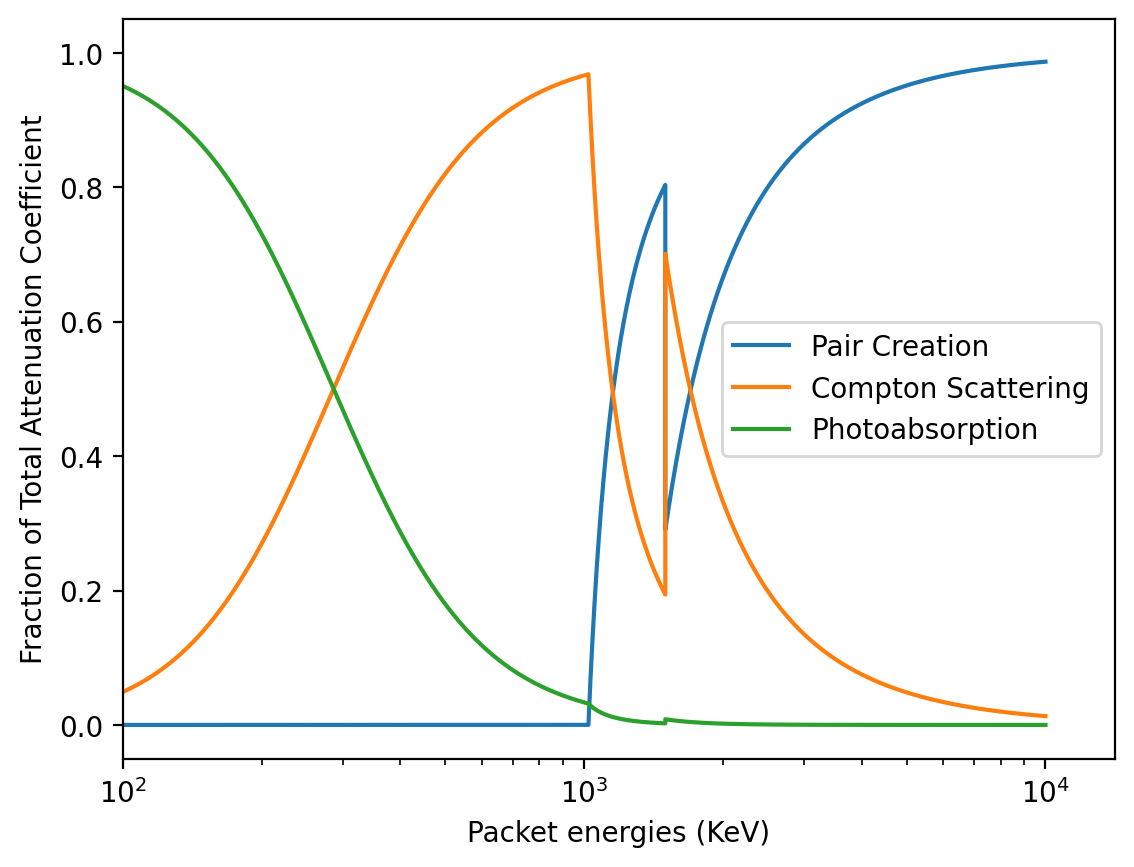

In [9]:
total_opacity = pair_creation_opacities + compton_opacities + photoabsorption_opacities
frac_pair_creation = pair_creation_opacities / total_opacity
frac_compton_scattering = compton_opacities / total_opacity
frac_photoabsorption = photoabsorption_opacities / total_opacity

plt.plot(energies, frac_pair_creation, label = "Pair Creation")
plt.plot(energies, frac_compton_scattering, label = "Compton Scattering")
plt.plot(energies, frac_photoabsorption, label = "Photoabsorption")
plt.xscale("log")
plt.xlim(left = 100)
plt.legend()
plt.xlabel("Packet energies (KeV)")
plt.ylabel("Fraction of Total Attenuation Coefficient")

Note that the above graphs may not be the same for every simulation. For example if the number density of electrons is much larger, Compton Scattering can be the the dominant source of opacity for this entire energy range.